# Supermarket Sales: Global Explanations

Shenyue jia

## Data Information

- The salary data for data scientist is collected and prepared by [Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/).

### Data Dictionary

Variable Name  | Description
-------------------|------------------
Item_Identifier	| Unique product ID
Item_Weight	| Weight of product
Item_Fat_Content	| Whether the product is low fat or regular
Item_Visibility	| The percentage of total display area of all products in a store allocated to the particular product
Item_Type	| The category to which the product belongs
Item_MRP	| Maximum Retail Price (list price) of the product
Outlet_Identifier	| Unique store ID
Outlet_Establishment_Year	| The year in which store was established
Outlet_Size	| The size of the store in terms of ground area covered
Outlet_Location_Type	| The type of area in which the store is located
Outlet_Type	| Whether the outlet is a grocery store or some sort of supermarket
Item_Outlet_Sales	| Sales of the product in the particular store. This is the target variable to be predicted.

## Analysis preparation

### Imports

In [1]:
# data wrangling
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

import shap
shap.initjs()
from lime.lime_tabular import LimeTabularExplainer

# machine learning
import joblib

### Visualization setup

In [11]:
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

### Set random state for reproducibility

In [2]:
SEED = 321
np.random.seed(SEED)

### Load model

- Previously, we saved a `DecisionTreeRegressor` model

In [3]:
# load model from pre-saved joblib file
loaded_joblib = joblib.load('best-models.joblib')
loaded_joblib.keys()

dict_keys(['preprocessor', 'X_train', 'y_train', 'X_test', 'y_test', 'LinearRegression', 'DecisionTreeRegressor'])

In [4]:
# save parameters to variables
preprocessor = loaded_joblib['preprocessor']
X_train = loaded_joblib['X_train']
y_train = loaded_joblib['y_train']
X_test = loaded_joblib['X_test']
y_test = loaded_joblib['y_test']
LinearRegression = loaded_joblib['LinearRegression']
DecisionTreeRegressor = loaded_joblib['DecisionTreeRegressor']

## Explain the tree-based model with `Shap`

### Create an `X_shap` and `y_shap` variable from the training data

In [5]:
# sample a subset of the data
X_shap = shap.sample(X_train, nsamples = 500, random_state = SEED)

In [6]:
# use the index of X_shap to slice out the corresponding y data 
y_shap = y_train.loc[X_shap.index]

### Create a model explainer

In [8]:
explainer = shap.Explainer(DecisionTreeRegressor)
explainer

### Calculate the shap values for the model

In [9]:
# assemble a model explainer with X_shap and y_shap
shap_values = explainer(X_shap, y_shap)
shap_values.shape

(500, 42)

In [10]:
# get dimension of X_shap
X_shap.shape

(500, 42)

- The dimension of shap values is the same as X data

### Create a summary plot with `plot_type = 'bar'`

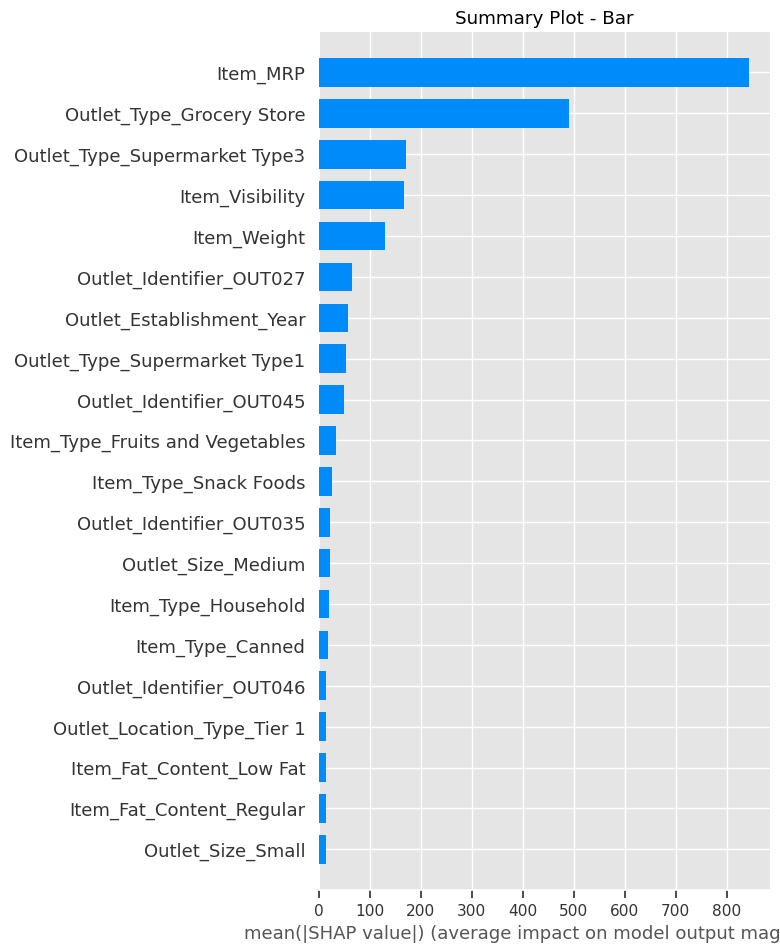

In [12]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values, X_shap, plot_type = 'bar', show = False)
ax.set_title('Summary Plot - Bar');
fig.savefig('PNG/Summary_Plot_Bar.png')

- In previous analysis, we excluded features derived from `Outlet_Identifier` as they are the IDs of outlets
- The features displayed below do not include any features derived from `Outlet_Identifier`
- We can see the top 5 most important features derived from the model and by SHAP are slightly different (in orders)
    - `Item_Visibility` ranked #3 in the result from model, but ranked #4 in results by SHAP
    - `Item_Visibility` ranked #4 in the result from model, but ranked #5 in results by SHAP
    - `Outlet_Type_Supermarket Type3` ranked #5 in the result from model, but ranked #3 in results by SHAP

Rank | Model | SHAP
-----| -----| ----
1 | `Item_MRP`| `Item_MRP`
2 | `Outlet_Type_Grocery Store` | `Outlet_Type_Grocery Store`
3 | `Item_Visibility` | `Outlet_Type Supermarket Type3`
4 | `Item_Weight` | `Item_Visibility`
5 | `Outlet_Type_Supermarket Type3` | `Item_Weight`

### Create a second summary plot - with `plot_type='dot'`

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


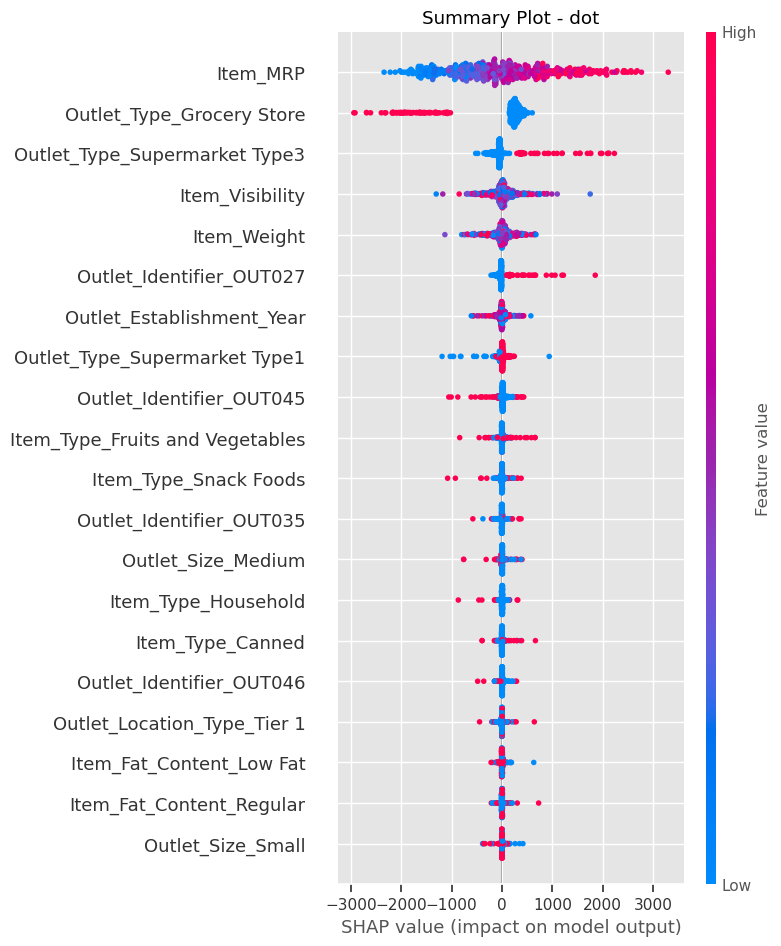

In [13]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values, X_shap, show = False)
ax.set_title('Summary Plot - dot');
fig.savefig('PNG/Summary_Plot_dot.png')

- The Top 3 most important features according to SHAP are `Item_MRP`, `Outlet_Type_Grocery Store`, and `Outlet_Type Supermarket Type3`
    - `Item_MRP`
        - Positive values (red dots on the right). The greater the maximum retail price of an item, the higher the model will predict as the item outlet sales.
        - Negative values (blue dots on the left). The smaller the maximum retail price of an item, the lower the model will predict as the item outlet sales.
    - `Outlet_Type_Grocery Store`
        - Positive values (red dots on the left). If items are more likely to be sold in Grocery Store, it tend to have a lower value in sales.
        - Negative values (blue dots on the right). If items are less likely to be sold in Grocery Store, it tend to have a higher value in sales.
    - `Outlet_Type Supermarket Type3`
        - Positive values (red dots on the right). If items are more likely to be sold in Type3 Supermarket, it tend to have a higher value in sales.
        - Negative values (blue dots on the left). If items are less likely to be sold in Type3 Supermarket, it tend to have a lower value.